In [124]:
__author__ = 'Vinicius Bobato'

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from json_parser import Wireshark_JSON_Parser
import ipaddress
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Pre-processing

In [2]:
mitm_parser = Wireshark_JSON_Parser('data/mitm_June5/June5_MITM_JSON.json')
normal_parser = Wireshark_JSON_Parser('data/mitm_June5/June5_normal_JSON.json')

In [3]:
mitm_df = mitm_parser.build_dataframe()
normal_df = normal_parser.build_dataframe()

In [4]:
def ip_in_subnet(ip):
    IP = ipaddress.ip_address(ip)
    subnet = ipaddress.ip_network("172.24.9.0/24")
    return IP in subnet

In [5]:
mitm_df = mitm_df[
    mitm_df['ip.src'].apply(ip_in_subnet) &
    mitm_df['ip.dst'].apply(ip_in_subnet)
]

normal_df = normal_df[
    normal_df['ip.src'].apply(ip_in_subnet) &
    normal_df['ip.dst'].apply(ip_in_subnet)
]

In [6]:
mitm_df['label'] = 1
normal_df['label'] = 0

C:\Users\vinib\AppData\Local\Temp\ipykernel_125560\2772800385.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mitm_df['label'] = 1
C:\Users\vinib\AppData\Local\Temp\ipykernel_125560\2772800385.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_df['label'] = 0


In [7]:
merged_df = pd.concat([mitm_df, normal_df], axis=0, ignore_index=True)
merged_df = merged_df.drop(['data.data'], axis=1)
merged_df.head()

,frame.protocols,frame.len,frame.time_delta,frame.time_relative,eth.src,eth.dst,ip.src,ip.dst,ip.ttl,ip.len,...,tcp.flags.ece,tcp.flags.urg,tcp.flags.ack,tcp.flags.push,tcp.flags.reset,tcp.flags.syn,tcp.flags.fin,tcp.checksum.status,data.len,label
0,eth:ethertype:ip:tcp:data,82,0.000089748,2.264673819,00:00:00:aa:00:13,00:00:00:aa:00:02,172.24.9.6,172.24.9.18,64,68,...,0,0,1,1,0,0,0,2,0,1
1,eth:ethertype:ip:tcp,66,0.000058388,2.264732207,00:00:00:aa:00:02,00:00:00:aa:00:13,172.24.9.18,172.24.9.6,61,52,...,0,0,1,0,0,0,0,2,16,1
2,eth:ethertype:ip:tcp:data,94,0.433302244,3.424372067,00:00:00:aa:00:02,00:00:00:aa:00:01,172.24.9.34,172.24.9.5,62,80,...,0,0,1,1,0,0,0,2,0,1
3,eth:ethertype:ip:tcp:data,94,0.000053214,3.424425281,00:00:00:aa:00:02,00:00:00:aa:00:01,172.24.9.34,172.24.9.2,62,80,...,0,0,1,1,0,0,0,2,28,1
4,eth:ethertype:ip:tcp:data,94,0.000029552,3.424454833,00:00:00:aa:00:02,00:00:00:aa:00:01,172.24.9.34,172.24.9.3,62,80,...,0,0,1,1,0,0,0,2,28,1


In [8]:
cat_vars = [
    'frame.protocols', 'eth.src', 'eth.dst', 'ip.src', 'ip.dst'
]

cont_vars = [
    'frame.len', 'frame.time_delta', 'frame.time_relative',
    'ip.ttl', 'ip.len', 'tcp.srcport', 'tcp.dstport', 'tcp.window_size_value',
    'tcp.flags.res', 'tcp.flags.ae', 'tcp.flags.cwr', 'tcp.flags.ece',
    'tcp.flags.urg', 'tcp.flags.ack', 'tcp.flags.push', 'tcp.flags.reset',
    'tcp.flags.syn', 'tcp.flags.fin', 'tcp.checksum.status', 'data.len'
]

label_encoders = {}

for col in cat_vars:
    le = LabelEncoder()
    merged_df[col] = le.fit_transform(merged_df[col].astype(str))
    label_encoders[col] = le 

In [9]:
merged_df.head()

,frame.protocols,frame.len,frame.time_delta,frame.time_relative,eth.src,eth.dst,ip.src,ip.dst,ip.ttl,ip.len,...,tcp.flags.ece,tcp.flags.urg,tcp.flags.ack,tcp.flags.push,tcp.flags.reset,tcp.flags.syn,tcp.flags.fin,tcp.checksum.status,data.len,label
0,1,82,0.000089748,2.264673819,6,1,6,0,64,68,...,0,0,1,1,0,0,0,2,0,1
1,0,66,0.000058388,2.264732207,1,6,0,6,61,52,...,0,0,1,0,0,0,0,2,16,1
2,1,94,0.433302244,3.424372067,1,0,3,5,62,80,...,0,0,1,1,0,0,0,2,0,1
3,1,94,0.000053214,3.424425281,1,0,3,1,62,80,...,0,0,1,1,0,0,0,2,28,1
4,1,94,0.000029552,3.424454833,1,0,3,2,62,80,...,0,0,1,1,0,0,0,2,28,1


In [10]:
merged_df['label'].value_counts()

label
1    680
0    612
Name: count, dtype: int64

In [11]:
train_df, val_df = train_test_split(merged_df, test_size=0.2, stratify=merged_df['label'], random_state=42)

In [12]:
train_df

,frame.protocols,frame.len,frame.time_delta,frame.time_relative,eth.src,eth.dst,ip.src,ip.dst,ip.ttl,ip.len,...,tcp.flags.ece,tcp.flags.urg,tcp.flags.ack,tcp.flags.push,tcp.flags.reset,tcp.flags.syn,tcp.flags.fin,tcp.checksum.status,data.len,label
844,1,94,0.000228310,508.136922312,4,1,1,3,64,80,...,0,0,1,1,0,0,0,2,0,0
927,0,66,0.000070965,524.432453018,1,5,3,5,62,52,...,0,0,1,0,0,0,0,2,28,0
941,0,66,0.000069020,529.759937429,3,1,2,3,64,52,...,0,0,1,0,0,0,0,2,28,0
622,1,94,0.000504153,137.267044107,0,1,5,3,63,80,...,0,0,1,1,0,0,0,2,0,1
1070,1,82,0.000283047,558.290756246,6,1,6,0,64,68,...,0,0,1,1,0,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,0,66,0.001405529,84.840905805,0,1,5,3,63,52,...,0,0,1,0,0,0,0,2,28,1
752,1,94,0.000137399,486.521437996,1,3,3,2,62,80,...,0,0,1,1,0,0,0,2,0,0
37,1,94,0.000121885,10.827065016,1,0,3,1,62,80,...,0,0,1,1,0,0,0,2,28,1
483,0,66,0.001983210,107.027413913,0,1,1,3,63,52,...,0,0,1,0,0,0,0,2,0,1


In [13]:
val_df

,frame.protocols,frame.len,frame.time_delta,frame.time_relative,eth.src,eth.dst,ip.src,ip.dst,ip.ttl,ip.len,...,tcp.flags.ece,tcp.flags.urg,tcp.flags.ack,tcp.flags.push,tcp.flags.reset,tcp.flags.syn,tcp.flags.fin,tcp.checksum.status,data.len,label
594,1,94,0.002709339,129.924807712,0,1,4,3,63,80,...,0,0,1,1,0,0,0,2,0,1
456,1,94,0.002221265,100.323051810,0,1,2,3,63,80,...,0,0,1,1,0,0,0,2,0,1
910,1,94,0.000252546,522.961412721,5,1,5,3,64,80,...,0,0,1,1,0,0,0,2,0,0
881,0,66,0.000034574,515.600947463,1,3,3,2,62,52,...,0,0,1,0,0,0,0,2,28,0
436,1,94,0.002389357,94.362345557,0,1,1,3,63,80,...,0,0,1,1,0,0,0,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,0,66,0.000055054,552.057246730,5,1,5,3,64,52,...,0,0,1,0,0,0,0,2,28,0
216,1,94,0.000988515,48.466368502,0,1,1,3,63,80,...,0,0,1,1,0,0,0,2,0,1
64,1,94,0.000670752,12.971011670,0,1,2,3,63,80,...,0,0,1,1,0,0,0,2,0,1
172,1,94,0.490844721,40.406818944,1,0,3,5,62,80,...,0,0,1,1,0,0,0,2,0,1


In [14]:
class Dataset(Dataset):
    def __init__(self, df, cat_cols, cont_cols, label, scaler=None, train=False):
        self.cat_cols = cat_cols
        self.cont_cols = cont_cols
        self.label = label
        self.x_cat = torch.tensor(df[cat_cols].values, dtype=torch.long)
        if scaler:
            if train:
                df[cont_cols] = scaler.fit_transform(df[cont_cols])
            else:
                df[cont_cols] = scaler.transform(df[cont_cols])
        self.x_cont = torch.tensor(df[cont_cols].values, dtype=torch.float32)
        self.y = torch.tensor(df[label].values, dtype=torch.long)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return self.x_cat[index], self.x_cont[index], self.y[index]

In [15]:
scaler = StandardScaler()

train_dataset = Dataset(train_df, cat_vars, cont_vars, scaler=scaler, label='label', train=True)
val_dataset = Dataset(val_df, cat_vars, cont_vars, scaler=scaler, label='label', train=False)

Model

In [16]:
class Model(nn.Module):
    def __init__(self, embedding_info, n_cont, hidden_dim=128, out_dim=2, dropout=0.3):
        super(Model, self).__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_cat, emb_dim) for num_cat, emb_dim in embedding_info
        ])
        self.emb_drop = nn.Dropout(dropout)

        total_emb_dim = sum([emb_dim for _, emb_dim in embedding_info])
        input_dim = total_emb_dim + n_cont

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, out_dim)
        self.drop = nn.Dropout(dropout)

    def forward(self, x_cat, x_cont):
        x = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        x = torch.cat(x, dim=1)
        x = self.emb_drop(x)

        x = torch.cat([x, x_cont], dim=1)
        x = nn.functional.relu(self.bn1(self.fc1(x)))
        x = self.drop(x)
        x = nn.functional.relu(self.bn2(self.fc2(x)))
        x = self.drop(x)
        return self.fc3(x)

In [17]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [18]:
embedding_info = []
for col in cat_vars:
    num_unique = merged_df[col].nunique()
    emb_dim = min(50, (num_unique + 1) // 2)
    embedding_info.append((num_unique, emb_dim))

n_cont = len(cont_vars)

In [19]:
model = Model(embedding_info, n_cont=n_cont)

In [20]:
model.state_dict()

OrderedDict([('embeddings.0.weight',
              tensor([[ 1.0067],
                      [-0.4334]])),
             ('embeddings.1.weight',
              tensor([[ 1.0250, -0.6869,  1.6511,  0.3603],
                      [-0.1602,  0.0179, -0.8559,  2.7802],
                      [-0.3455,  0.4997, -0.8832, -0.2785],
                      [-0.6539, -0.0807, -0.4392,  1.1417],
                      [ 1.3278,  1.1537,  1.8003, -1.8185],
                      [ 0.5256, -0.6747,  1.2535, -0.9075],
                      [-0.4660, -1.0849,  0.6672, -0.2671]])),
             ('embeddings.2.weight',
              tensor([[-0.7090, -0.2752,  1.2244,  1.1278],
                      [-1.7628, -0.5103,  0.1506, -0.5113],
                      [ 0.8782,  0.0330, -2.0508,  0.0554],
                      [ 0.1932, -1.0689,  0.0088, -0.0086],
                      [-0.4723,  1.5444,  0.8016,  0.8041],
                      [ 2.0141, -2.1216, -0.0047, -1.0303],
                      [ 0.0308, -0.97

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training the Model

In [22]:
epochs = 10
LOSS = []
ACC = []
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x_cat, x_cont, y in train_dataloader:
        optimizer.zero_grad()
        outputs = model(x_cat, x_cont)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_dataloader)
    LOSS.append(avg_train_loss)
    
    # Validate Model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x_cat, x_cont, y in valid_dataloader:
            outputs = model(x_cat, x_cont)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    val_accuracy = correct / total
    ACC.append(val_accuracy)

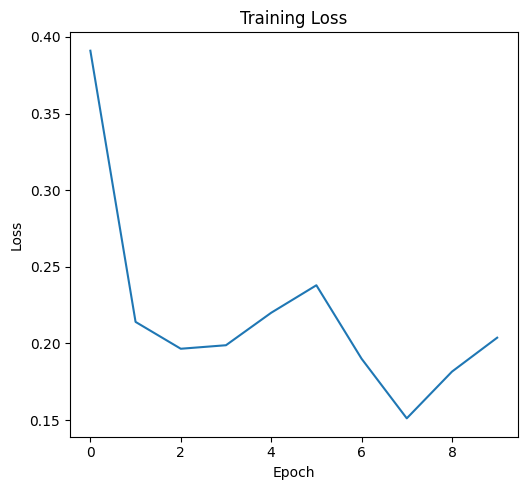

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(LOSS, label='Train Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")

plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       123
           1       0.97      1.00      0.99       136

    accuracy                           0.98       259
   macro avg       0.99      0.98      0.98       259
weighted avg       0.98      0.98      0.98       259



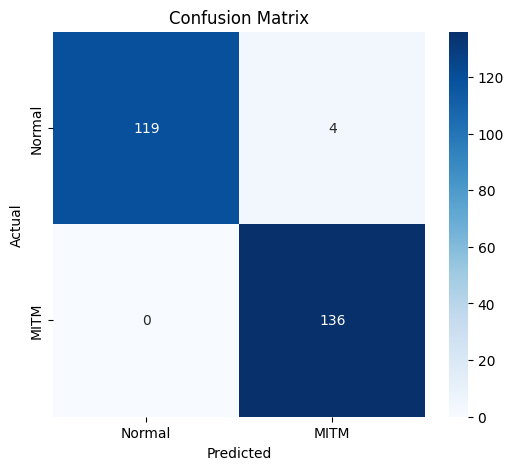

In [24]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for x_cat, x_cont, y in valid_dataloader:
        outputs = model(x_cat, x_cont)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.tolist())
        all_targets.extend(y.tolist())

print(classification_report(all_targets, all_preds))
cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'MITM'], yticklabels=['Normal', 'MITM'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [25]:
torch.save(model.state_dict(), 'trained_models/June5_mitm.pth')